<a href="https://colab.research.google.com/github/maggiemcc02/Adaptive_Meshing/blob/main/deBoor_Meshes/General_deBoor_AdaptiveMesh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this notebook, I construct a function which couples my nonlinear, non-uniform physical solver (uses Newton's Method) with the de Boor mesh solver (uses de Boor's algorithm to equidistribute the Mesh Density Function). 

I then test this code by using it to compute the three solutions to the reaction diffusion problem given as $2.6$ in Kopteva's *Numerical Analysis of Singularly Perturbed Nonlinear Reaction-Diffusion Problems with Multiple Solutions.*


### BY: Maggie McCarthy, June 2022



In [1]:
# import needed tools
import math
import numpy as np
from scipy.linalg import solve_banded
from numpy.linalg import norm
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# The Test Problem from Kopteva's Paper

In [2]:
def k(u, t):
  return u*(u-1)*(u-t-(3/2))

def k_prime(u, t):
  return 3*u**2 - 2*u*t + (-10*u + 3) / 2 + t

u_0 = 3/2
u_n = 1/2

# Non-Uniform Nonlinear Physical Solver

The notebook where I discretize the problem, create and test this solver : https://colab.research.google.com/drive/1YBNZJnpjLUEzcm4TjqQDVCMW56-AyqFW?usp=sharing

In [3]:
# Nonlinear, non-uniform, physical solver

def newton_method_bvp(G, J, grid, k, k_prime, x0, u_0, u_n, E, tol, max_iter):
  """
  Approximates the solution to a specific nonlinear system
  Parameters
  ---------
  G : Vector function
      Is the system of nonlinear equations
  
  J : Jacobian Matrix of G

  grid : vector of grid points

  k : Known function in ODE

  k_prime : derivative of k

  x0 :  Vector of initial guesses for each unknown. 
        If f has 4 unknowns, x0 has shape 4 X 1
  
  u_0, u_n : boundary conditions

  E : Epsilon (see text)

  tol : number 
        Tolerance

  max_iter: integer
            Max number of iterations

  Returns
  ------
  An approximation for the solutions of G(x) = 0 where G is a nonlinear system.
  """

  # Remove the first and last entries of the grid
  # this is because we already have the solution
  # at the boundary values (u_0 and u_1)
  
  #global mesh
  mesh = []
  for i in range(len(grid)):
    if i != 0: # if not first entry
      if i != (len(grid)-1): # if not last entry
        mesh.append([ grid[i][0] ]) # then add it to new vector
  mesh = np.array(mesh)
  

  # Calculate the mesh width (h) for each grid point
  # h_i = x_i - x_i-1

  h_list = []
  for i in range(1, len(grid)):
      h = grid[i][0] - grid[i-1][0]
      h_list.append( [h] )
  mesh_space = np.array(h_list)

  xn = x0 # sets initial guesses as xn for the first iteration of the loop
  
  for n in range(1, max_iter):

    # compute b = -G(X)
    
    b = (-1) * G(xn, mesh, mesh_space, k, u_0, u_n, E)

    # compute A = J(X)

    A = J(xn, mesh, mesh_space, k, k_prime, u_0, u_n, E)
    

    # solve the system with scipy's solve_banded
    # we can use this solver because A is tridiagonal

    delta = solve_banded((1,1), A, b)
    
    x_new = xn + delta
    

    if norm(x_new - xn) < tol:
      
      # x_new is our solution
      # add in the boundary conditions
      
      solutions_list = [[u_0]]
      for i in x_new:
        solutions_list.append(i)
      solutions_list.append([u_n])
      solutions = np.array(solutions_list)

      return solutions


    xn = x_new

  print('Max iterations reached and/or sequence is diverging')
  return None

In [4]:
# Our System

def G(x, mesh, mesh_spacing, k, u_0, u_n, E):

  """
  x : array of guesses
  mesh : vector of grid points
  mesh_spacing : vector of mesh widths
  k : our function in the ODE
  u_0, u_n : boundary conditions
  E : epsilon

  """
  g_list = []

  for i in range(len(x)):

    # set the grid point
    point = mesh[i][0]
    # set mesh width
    h1 = mesh_spacing[i][0]
    h2 = mesh_spacing[i+1][0]

    # create entries
    if (i == 0): # u_i-1 is u_0

      u_1 = x[i][0]
      u_2 = x[i+1][0]
      u_minus = u_0

      g_list.append( [ ( ( h1*u_2 + h2*u_minus - (h1 + h2)*u_1 ) \
                        / ( (1/2) * (h1*(h2**2) + h2*(h1**2)) ) \
                        - ( (k(u_1, point)) / (E**2) ) ) ] )
   
      
    elif i == (len(x) - 1): # U_i+1 is u_n

      u_1 = x[i][0]
      u_2 = u_n
      u_minus = x[i-1][0]  

      g_list.append( [ ( ( h1*u_2 + h2*u_minus - (h1 + h2)*u_1 ) \
                        / ( (1/2) * (h1*(h2**2) + h2*(h1**2)) ) \
                        - ( (k(u_1, point)) / (E**2) ) ) ] )

    else:

      u_1 = x[i][0]
      u_2 = x[i+1][0]
      u_minus = x[i-1][0]  

      g_list.append( [ ( ( h1*u_2 + h2*u_minus - (h1 + h2)*u_1 ) \
                        / ( (1/2) * (h1*(h2**2) + h2*(h1**2)) ) \
                        - ( (k(u_1, point)) / (E**2) ) ) ] )

      
    
    

  # create array 
  G = np.array(g_list)
  return G

In [5]:
# Our Jacobian

def J(x, mesh, mesh_spacing, k, k_prime, u_0, u_n, E):

  """
  x : array of guesses
  mesh : vector of grid points
  mesh_spacing : vector of mesh widths
  k : function in ODE
  k_prime : derivaive of function in ODE
  E : epsilon

  """


  main  = []
  upper = []
  lower = []
 

  for i in range(len(x)):

    # set grid point
    point = mesh[i][0]
    # set mesh width
    h1 = mesh_spacing[i][0]
    h2 = mesh_spacing[i+1][0]



    # create diagonals 

    if i == 0: # first row

      main.append( ( (-1*(h1+h2)) / ( (1/2)*(h1*(h2**2) + h2*(h1**2)) ) ) - ( (1 / (E**2)) * ( k_prime(x[i][0], point)) ) )
      upper.append(0)
      upper.append( h1 / ( (1/2)* (h1*(h2**2) + h2*(h1**2)) ) )

    elif i == (len(x)-1): # last row

      main.append( ( (-1*(h1+h2)) / ( (1/2)*(h1*(h2**2) + h2*(h1**2)) ) ) - ( (1 / (E**2)) * ( k_prime(x[i][0], point)) ) )
      lower.append( h2 / ( (1/2)* (h1*(h2**2) + h2*(h1**2)) ) )
      lower.append(0)

    else: 

      upper.append( h1 / ( (1/2)* (h1*(h2**2) + h2*(h1**2)) ) )
      main.append( ( (-1*(h1+h2)) / ( (1/2)*(h1*(h2**2) + h2*(h1**2)) ) ) - ( (1 / (E**2)) * ( k_prime(x[i][0], point)) ) )
      lower.append( h2 / ( (1/2)* (h1*(h2**2) + h2*(h1**2)) ) )

    

  # create banded array
  jacob = np.array([upper, main, lower])

  return jacob 

# de Boor's Algorithm (Mesh Solver) 

The notebook where I created and tested this method : 

 https://colab.research.google.com/drive/1bGt-mo34X-DQ7LtHbdjcpU7eBSABiJqz?usp=sharing

## Mesh Density Function

In [6]:
# mesh density function for interior nodes without prints

def interior_M(Uc, Ua, xc, xb, xa):

  """
  Uc : U_i+1 
  Ua : U_i-1
  xc, xb, xa : corresponding grid points
  """

  U0 = Ua # U_i-1
  U2 = Uc # U_i+1

  h1 = xb - xa
  h2 = xc - xb

  ux = (U2 - U0) / (h2 + h1)

  approx = np.sqrt(1 + (ux)**2)

  return approx

In [7]:
# mesh density function for endpoints without prints

def endpoint_M(Ub, Ua, xb, xa):
  """
  Ub : U_i+1 or Ui
  Ua : Ui or U_i-1
  xb, xa : corresponding grid points
  """
  ux = (Ub - Ua) / (xb - xa)


  approx = np.sqrt( 1 + (ux)**2)

  return approx

In [8]:
# code to generate M values on a given grid
# same as before without prints

def M_calc(U, grid):


  rho = [] # empty list to save M values

  rho.append(endpoint_M(U[1][0], U[0][0], grid[1][0], grid[0][0])) # add M value at first grid point using forward approx

  for i in range(len(grid)-2): # add M values for interior nodes


    # set values of U and y to pass to mesh density function

    U0 = U[i][0]
    U2 = U[i+2][0]
    x0 = grid[i][0]
    x1 = grid[i+1][0]
    x2 = grid[i+2][0]

    val = interior_M(U2, U0, x2, x1, x0) # compute mesh density
    
    rho.append(val)


  rho.append(endpoint_M(U[-1][0], U[-2][0], grid[-1][0], grid[-2][0])) # add M value for last grid point

  rho = np.array([rho]).T

  return rho

## P(x) Function 
$$P(y_j) = \sum^{j}_{i=1} (y_i - y_{i-1}) \frac{\rho(y_i) + \rho(y_{i-1})}{2} \text{ for } j = 1, \dots, N-1.$$

In [9]:
# define P without prints

def P(j, old_mesh, rho):

  """
  j : index of grid point we want to calculate P at j = 1, ..., N-1
  
  old_mesh : current mesh / old mesh

  rho : vector of mesh density function values at each grid point in old_mesh

  """

  p_j = 0

  for i in range(1, j+1):
    

    y1 = old_mesh[i-1][0]
    y2 = old_mesh[i][0]
    M1 = rho[i-1][0]
    M2 = rho[i][0]

    val = (y2 - y1) * ( (M2 + M1) / 2)


    p_j += val

  return p_j

## The Mesh Solver (de Boor)


In [10]:
def equidistribute(oldmesh, P, rho, uni_grid, x0, xn):
  """
  oldmesh : current mesh we are updating with this code

  P : function defined in Russell and Huang which represents the integral of the linearized mesh density function

  rho : value of the mesh density function at each point on the oldmesh

  uni_grid : a uniform grid with the same number of points and on the same interval the oldmesh

  x0, xn : first and last grid points
  """

  # compute P(y) for each y in oldmesh

  #print('Computing P(y) values:')

  P_list = [0] # P(a) = 0

  for q in range(1, len(oldmesh)): # q = second grid point, ..., last grid point

    P_list.append(P(q, oldmesh, rho)) 


  # main code to compute the new grid points

  newmesh = [x0] # add in boundary condition x(0) = 0


  for j in range(1, len(oldmesh)-1): # j = second grid point, ..., second last grid point 

    # compute xi * P(b)

    xi = uni_grid[j][0] # THIS COULD BE REPLACED WITH j/N

    P_b = P_list[-1] # P(b) is last P value in P_list

    xi_pb = xi * P_b # compute xi * P(b)


    # find what interval on the old mesh xi*P(b) is in

    for i in range(1, len(oldmesh)):


      P_y2 = P_list[i] #P(y_i)
      P_y1 = P_list[i-1] #P(y_i-1)


      if ((xi_pb > P_y1) and (xi_pb <= P_y2)): # if P(y_i-1) < xi*P(b) <= P(y_i)
        
        # set k = i

        k = i

        break

    
    # compute the new mesh point


    a = oldmesh[k-1][0] # a = y_k-1

    b = 2 * ( xi_pb - P_list[k-1] ) # b = 2 * (xi*P(b) - P(y_k-1))

    c = rho[k-1][0] + rho[k][0] # c = M(y_k-1) + M(y_k)

    new_x = a + b / c # new_x = y_k-1 + ( 2 * (xi*P(b) - P(y_k-1))) / (M(y_k-1) + M(y_k))

    newmesh.append(new_x) # save new grid point to mesh

  newmesh.append(xn) # save endpoint to end of mesh
  newmesh = np.array([newmesh]).T # make mesh a column vector 


  return newmesh

# General Code for Coupling

This code differs from my previous code by using the previous $U$ vector (solution approximation from the physical solver) as the initial guess needed by the physical solver to compute a new $U.$

Previously, I used a constant initial guess for every call of the physical solver in the coupling.

In [11]:
def adaptive_mesh(mesh, uni_grid, guess, n):


  # create table to print results
  print('Mesh #    l2 Norm of Old Mesh - New Mesh          l2 Norm of Old U - New U')
  print('_'*80)

  # approximate on a uniform mesh using this guess

  U = newton_method_bvp(G, J, mesh, k, k_prime, guess, u_0, u_n, 0.01, 1e-12, 100)

  # set new initial guess as U

  guess = []
  for i in range(len(U)):
    if i != 0:
      if i != (len(U)-1):
        val = [  U[i][0]  ]
        guess.append(val)
  guess = np.array( guess )


  # loop to couple codes

  for i in range(n): # couple code 50 times


    print(i + 1, end = '         ')

    # compute mesh density function

    M_vals = M_calc(U, mesh)

    # equidistribute (mesh solver with de Boor)

    new_mesh = equidistribute(mesh, P, M_vals, uni_grid, 0, 1)

    # print norm(old mesh - new mesh)

    print(norm(abs(new_mesh-mesh)), end = '                       ')

    # update the mesh

    mesh = new_mesh

    # set current U as guess
  
    guess = []
    for i in range(len(U)):
      if i != 0:
        if i != (len(U)-1):
          val = [  U[i][0]  ]
          guess.append(val)
    guess = np.array( guess )

    # compute new U

    new_U = newton_method_bvp(G, J, mesh, k, k_prime, guess, u_0, u_n, 0.01, 1e-12, 100)


    print(norm(abs(new_U - U)))

    # set new_U as U

    U = new_U
  
  # create final grid as global variable

  global final_mesh
  final_mesh = []
  for i in range(len(mesh)):
    final_mesh.append(mesh[i][0])


  return U

# Test Problems

I will now recover the three solutions to Kopteva's problem using the general coupling code and differant initial guesses.

I will output a table of $norm$ calculations. I will also plot the final approximation of the physical solution (after the coupling).

## First Solution - Initial Guess of $u(x) = 0$

Mesh #    l2 Norm of Old Mesh - New Mesh          l2 Norm of Old U - New U
________________________________________________________________________________
1         2.4061790757235233                       5.777522205294579
2         0.018636414569939915                       0.3784392897193424
3         0.006602383809064049                       0.013665650289249499
4         0.0008095279632485522                       0.0016931457455500861
5         0.00030569990995766476                       0.0005563880949406823
6         8.663571844747028e-05                       0.00025388346773492604
7         4.603822279029634e-05                       9.944746273988711e-05
8         1.9532085988976724e-05                       3.780944597839449e-05
9         9.062796483371787e-06                       1.5002415282052088e-05
10         3.7543256986922547e-06                       6.086827485949725e-06
11         1.1800977078388847e-06                       2.105675784111819e-06
12         2.

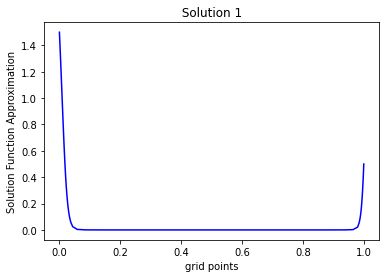

In [12]:
# set grids

grid = np.linspace(0, 1, 100)

mesh = np.array([grid]).T # initial mesh
uni_grid = np.array([grid]).T # uniform xi

# set initial guess u(x) = 0 

guess = []
for i in range(len(mesh)):
  if i != 0:
    if i != (len(mesh)-1):
      val = [  0  ]
      guess.append(val)
guess = np.array( guess )

# call function

final_U = adaptive_mesh(mesh, uni_grid, guess, 50)

print()
print()

# plot the result

plt.plot(final_mesh, final_U, 'b')
plt.xlabel('grid points')
plt.ylabel('Solution Function Approximation')
plt.title(" Solution 1 ")
plt.show()



## Second Solution - Initial Guess of $u(x) = x + \frac{3}{2}.$

Mesh #    l2 Norm of Old Mesh - New Mesh          l2 Norm of Old U - New U
________________________________________________________________________________
1         3.225552007326674                       7.589370055413647
2         0.015569809086139039                       0.7997195247665051
3         0.007923423561704439                       0.029941433339104637
4         0.001575149180540728                       0.007587593521685425
5         0.0005420329238188096                       0.001673746300524968
6         0.0003258899316175173                       0.00168300516707816
7         0.00020886873804562038                       0.0013232365921310135
8         9.131506589419742e-05                       0.0004007257539360483
9         6.694975852507036e-05                       0.0002850370907380499
10         3.4712749457443665e-05                       0.00014674073222876462
11         1.774442552659658e-05                       7.281207957079205e-05
12         9.472266549

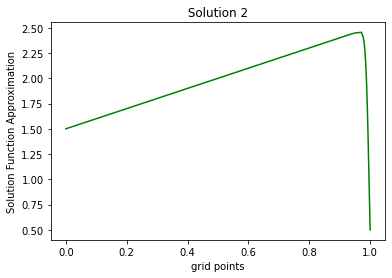

In [13]:
# set grids

grid = np.linspace(0, 1, 100)

mesh = np.array([grid]).T # initial mesh
uni_grid = np.array([grid]).T # uniform xi

# set initial guess u(x) = x + 3/2

guess = []
for i in range(len(mesh)):
  if i != 0:
    if i != (len(mesh)-1):
      val = [  mesh[i][0] + 3/2 ]
      guess.append(val)
guess = np.array( guess )

# call function

final_U = adaptive_mesh(mesh, uni_grid, guess, 50)

print()
print()

# plot the result

plt.plot(final_mesh, final_U, 'g')
plt.xlabel('grid points')
plt.ylabel('Solution Function Approximation')
plt.title(" Solution 2 ")
plt.show()

## Third Solution - Initial Guess of $u(x) = x$

Mesh #    l2 Norm of Old Mesh - New Mesh          l2 Norm of Old U - New U
________________________________________________________________________________
1         1.227910844998425                       6.8102733588814575
2         0.029255269378840536                       0.9302364974646528
3         0.01769377394185003                       0.059442111626335385
4         0.007395375717153334                       0.04632978927856383
5         0.005802928506436691                       0.08476570119216204
6         0.004016123499144592                       0.06641255287930718
7         0.00266633813619899                       0.0295127298727336
8         0.002123866508487669                       0.027834547026786435
9         0.0015928356237312914                       0.020732331428177788
10         0.001173362566608103                       0.014358071851028394
11         0.0008969724869222991                       0.011337614942291335
12         0.0006767160038955063        

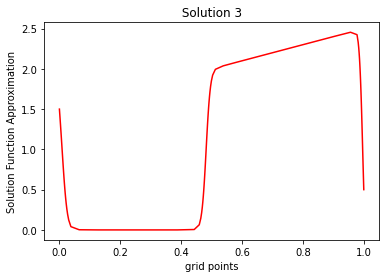

In [14]:
# set grids

grid = np.linspace(0, 1, 100)

mesh = np.array([grid]).T # initial mesh
uni_grid = np.array([grid]).T # uniform xi

# set initial guess u(x) = x

guess = []
for i in range(len(mesh)):
  if i != 0:
    if i != (len(mesh)-1):
      val = [  mesh[i][0]  ]
      guess.append(val)
guess = np.array( guess )

# call function

final_U = adaptive_mesh(mesh, uni_grid, guess, 50)

print()
print()

# plot the result

plt.plot(final_mesh, final_U, 'r')
plt.xlabel('grid points')
plt.ylabel('Solution Function Approximation')
plt.title(" Solution 3 ")
plt.show()

# Coupling With DownSampling 

I will now try to alter my code to reduce the number of points needed in the mesh to approximate the solution.

The plan is to compute the initial $U$ approximation (before coupling) as before. I will then take every second grid point (1st, 3rd, 5th, etc) so that the mesh and the corresponding $U$ vector are half the original size. 

Using this 'downsampled' mesh, I will continue with the coupling! This coupling will be cheaper than before because we are approximating on half the grid size.



## Pratice Downsampling

In [15]:
# pratice downsampling vectors 

# create fake x and U vectors

x = []
u = []
for i in range(1, 101):
  x.append(i)
  u.append(i)
x = np.array([x]).T
u = np.array([u]).T

# down sample

new_x = []
new_u = []
for i in range(100):
  if ( (i % 2) == 0 ):
    new_x.append(x[i][0])
    new_u.append(u[i][0])
print(len(new_x))
print(len(new_u))
print()
print(new_x)
print(new_u)

50
50

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99]
[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99]


## Couple Code with Downsampling

In [16]:
# Introduce downsampling into coupling code

def downsampling_adaptive_mesh(mesh, uni_grid, guess, n, N ):


  # approximate on a uniform mesh using this guess

  U = newton_method_bvp(G, J, mesh, k, k_prime, guess, u_0, u_n, 0.01, 1e-12, 100)

  # perform downsampling

  new_x = []
  new_xi = []
  new_u = []
  for i in range(N):
    if ( (i % 2) == 0 ): # for every evenly indexed term in vector 
      new_x.append(mesh[i][0])
      new_xi.append(uni_grid[i][0])
      new_u.append(U[i][0])
  
  print('length of new vectors')
  print()
  print(len(new_x))
  print(len(new_xi))
  print(len(new_u))

  print()

  print("if downsampling worked, these values should match!")
  print()
  print( mesh[2][0], new_x[1])
  print(U[8][0], new_u[4])
  print(uni_grid[10][0], new_xi[5])
  print()


  # set mesh, uni_grid, and U as downsampled arrays

  mesh = np.array([new_x]).T
  uni_grid = np.array([new_xi]).T
  U = np.array([new_u]).T

  # set new initial guess as U

  guess = []
  for i in range(len(U)):
    if i != 0:
      if i != (len(U)-1):
        val = [  U[i][0]  ]
        guess.append(val)
  guess = np.array( guess )

  # create table to print results
  print('Mesh #    l2 Norm of Old Mesh - New Mesh          l2 Norm of Old U - New U')
  print('_'*80)


  # loop to couple codes

  for i in range(n): # couple code 50 times


    print(i + 1, end = '         ')

    # compute mesh density function

    M_vals = M_calc(U, mesh)

    # equidistribute (mesh solver with de Boor)

    new_mesh = equidistribute(mesh, P, M_vals, uni_grid, 0, 1)

    # print norm(old mesh - new mesh)

    print(norm(abs(new_mesh-mesh)), end = '                       ')

    # update the mesh

    mesh = new_mesh

    # set current U as guess
  
    guess = []
    for i in range(len(U)):
      if i != 0:
        if i != (len(U)-1):
          val = [  U[i][0]  ]
          guess.append(val)
    guess = np.array( guess )

    # compute new U

    new_U = newton_method_bvp(G, J, mesh, k, k_prime, guess, u_0, u_n, 0.01, 1e-12, 100)


    print(norm(abs(new_U - U)))

    # set new_U as U

    U = new_U
  
  # create final grid as global variable

  global final_mesh
  final_mesh = []
  for i in range(len(mesh)):
    final_mesh.append(mesh[i][0])


  return U

## Test Problem - Try To Capture Third Solution

length of new vectors

50
50
50

if downsampling worked, these values should match!

0.020202020202020204 0.020202020202020204
0.00036895371963353016 0.00036895371963353016
0.10101010101010102 0.10101010101010102

Mesh #    l2 Norm of Old Mesh - New Mesh          l2 Norm of Old U - New U
________________________________________________________________________________
1         0.9461952041966085                       5.436417879288524
2         1.4803402174533558                       7.812561429071628
3         0.8422166820811472                       1.0963969856527014
4         0.39441736301727515                       0.9599462726310405
5         0.20749979187027232                       5.455324761055225
6         1.1701501369759875                       6.399723699431319
7         2.753762511008229                       2.8309684213982083
8         0.03537180458102608                       0.1622029585023343
9         0.005223489886083304                       0.02700189460790206

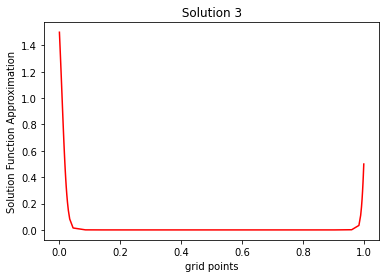

In [17]:
# set grids

grid = np.linspace(0, 1, 100)

mesh = np.array([grid]).T # initial mesh
uni_grid = np.array([grid]).T # uniform xi

# set initial guess u(x) = x

guess = []
for i in range(len(mesh)):
  if i != 0:
    if i != (len(mesh)-1):
      val = [  mesh[i][0]  ]
      guess.append(val)
guess = np.array( guess )

# call function

final_U = downsampling_adaptive_mesh(mesh, uni_grid, guess, 50, 100)

print()
print()

# plot the result

plt.plot(final_mesh, final_U, 'r')
plt.xlabel('grid points')
plt.ylabel('Solution Function Approximation')
plt.title(" Solution 3 ")
plt.show()

# Write DownSampling as a Function so that we can DownSample Numerous Times 


## DownSample Function

In [18]:
 def downsampling(mesh, uni_grid, U, N):

   """
   mesh : mesh we are halfing

   uni_grid : uniform grid we are halfing

   U : approximation vector we are halfing

   N : number of points originally

   """
 
   # perform downsampling

   global new_x
   global new_xi
   global new_u
   new_x = []
   new_xi = []
   new_u = []

   for i in range(N):
     if ( (i % 2) == 0 ): # for every evenly indexed term in vector 
       new_x.append(mesh[i][0])
       new_xi.append(uni_grid[i][0])
       new_u.append(U[i][0])

   new_x = np.array([new_x]).T
   new_u = np.array([new_u]).T
   new_xi = np.array([new_xi]).T
  
   print('length of new vectors')
   print()
   print(len(new_x))
   print(len(new_xi))
   print(len(new_u))





In [19]:
x = np.linspace(1, 10, 10)

mesh = np.array([x]).T
uni_grid = np.array([x]).T
U = np.array([x]).T


downsampling(mesh, uni_grid, U, 10 )

mesh = new_x
uni_grid = new_xi
U = new_u

print()

downsampling(mesh, uni_grid, U, len(mesh))

mesh = new_x
uni_grid = new_xi
U = new_u




length of new vectors

5
5
5

length of new vectors

3
3
3


## Coupling Code that can DownSample Numerous Times

In [20]:
# Introduce downsampling into coupling code

def downsampling_adaptive_mesh(mesh, uni_grid, guess, n, N, d):

  """
  mesh : initial mesh

  uni_grid : uniform grid

  guess : initial guess 

  n : number of couples

  N : number of grid points

  d : number of downsamples

  """


  # approximate on a uniform mesh using this guess

  U = newton_method_bvp(G, J, mesh, k, k_prime, guess, u_0, u_n, 0.01, 1e-12, 100)


  # perform downsampling

  points = N

  for i in range(d):

    downsampling(mesh, uni_grid, U, points )

    points = len(new_x)


  mesh = new_x
  uni_grid = new_xi
  U = new_u


  # set new initial guess as U

  guess = []
  for i in range(len(U)):
    if i != 0:
      if i != (len(U)-1):
        val = [  U[i][0]  ]
        guess.append(val)
  guess = np.array( guess )

  # create table to print results

  print()
  print('Mesh #    l2 Norm of Old Mesh - New Mesh          l2 Norm of Old U - New U')
  print('_'*80)


  # loop to couple codes

  for i in range(n): # couple code 50 times


    print(i + 1, end = '         ')

    # compute mesh density function

    M_vals = M_calc(U, mesh)

    # equidistribute (mesh solver with de Boor)

    new_mesh = equidistribute(mesh, P, M_vals, uni_grid, 0, 1)

    # print norm(old mesh - new mesh)

    print(norm(abs(new_mesh-mesh)), end = '                       ')

    # update the mesh

    mesh = new_mesh

    # set current U as guess
  
    guess = []
    for i in range(len(U)):
      if i != 0:
        if i != (len(U)-1):
          val = [  U[i][0]  ]
          guess.append(val)
    guess = np.array( guess )

    # compute new U

    new_U = newton_method_bvp(G, J, mesh, k, k_prime, guess, u_0, u_n, 0.01, 1e-12, 100)


    print(norm(abs(new_U - U)))

    # set new_U as U

    U = new_U
  
  # create final grid as global variable

  global final_mesh
  final_mesh = []
  for i in range(len(mesh)):
    final_mesh.append(mesh[i][0])


  return U

## Test Problem

length of new vectors

50
50
50
length of new vectors

25
25
25

Mesh #    l2 Norm of Old Mesh - New Mesh          l2 Norm of Old U - New U
________________________________________________________________________________
1         1.2082648824306539                       3.676028017302259
2         0.1360627307822177                       0.9687742698297083
3         0.05118770777971638                       0.3638059685442912
4         0.029002447982530943                       4.30518374478173
5         1.1960459444339315                       1.1963045835418584
6         0.5453443776238651                       0.5452637729223333
7         0.268705231884834                       0.2685772985952168
8         0.17424264869239436                       0.17406548547474263
9         0.12638287173849555                       0.1261483347293426
10         0.09532501789866518                       0.09501645206286168
11         0.07656907742505567                       0.07617818677005386
1

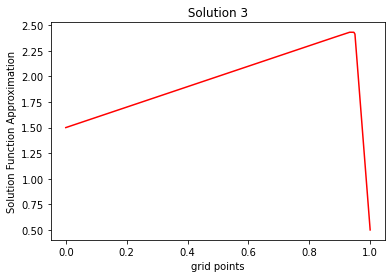

In [21]:
# set grids

grid = np.linspace(0, 1, 100)

mesh = np.array([grid]).T # initial mesh
uni_grid = np.array([grid]).T # uniform xi

# set initial guess u(x) = x

guess = []
for i in range(len(mesh)):
  if i != 0:
    if i != (len(mesh)-1):
      val = [  mesh[i][0]  ]
      guess.append(val)
guess = np.array( guess )

# call function

final_U = downsampling_adaptive_mesh(mesh, uni_grid, guess, 25, 100, 2)

print()
print()

# plot the result

plt.plot(final_mesh, final_U, 'r')
plt.xlabel('grid points')
plt.ylabel('Solution Function Approximation')
plt.title(" Solution 3 ")
plt.show()